## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

In [1]:
!pip install unidecode
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.9 MB/s eta 0:00:00


In [2]:
# Importación librerías
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Carga de la base de datos

In [3]:
dt= pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0).reset_index().drop("index",axis=1)

# Visualización de la base de datos

In [4]:
dt.head()

,year,title,plot,genres,rating
0,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
1,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
2,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
3,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
4,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


## Tamaño de la  base de datos

In [5]:
dt.shape

(7895, 5)

Se descartan las variables que no aportan al proyecto

In [6]:
dt=dt[["plot","genres"]]
dt.head()

,plot,genres
0,most is the story of a single father who takes...,"['Short', 'Drama']"
1,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']"
2,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']"
3,"in a friday afternoon in new york , the presi...",['Drama']
4,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']"


# Tipos de variables

In [7]:
dt.dtypes

plot      object
genres    object
dtype: object

# Peso de la base de datos

In [8]:
import sys
print("La base de datos tiene un peso de ",sys.getsizeof(dt)," bytes")

La base de datos tiene un peso de  7045029  bytes


# Cantidad de filas vacias en la base de datos

In [9]:
dt.isnull().sum()

plot      0
genres    0
dtype: int64

# Estadísticas del número de palabras en el resumen por película sin preprocesamiento

count    7895.000000
mean      159.937555
std       106.191251
min         1.000000
25%        88.000000
50%       140.000000
75%       202.000000
max      1977.000000
dtype: float64


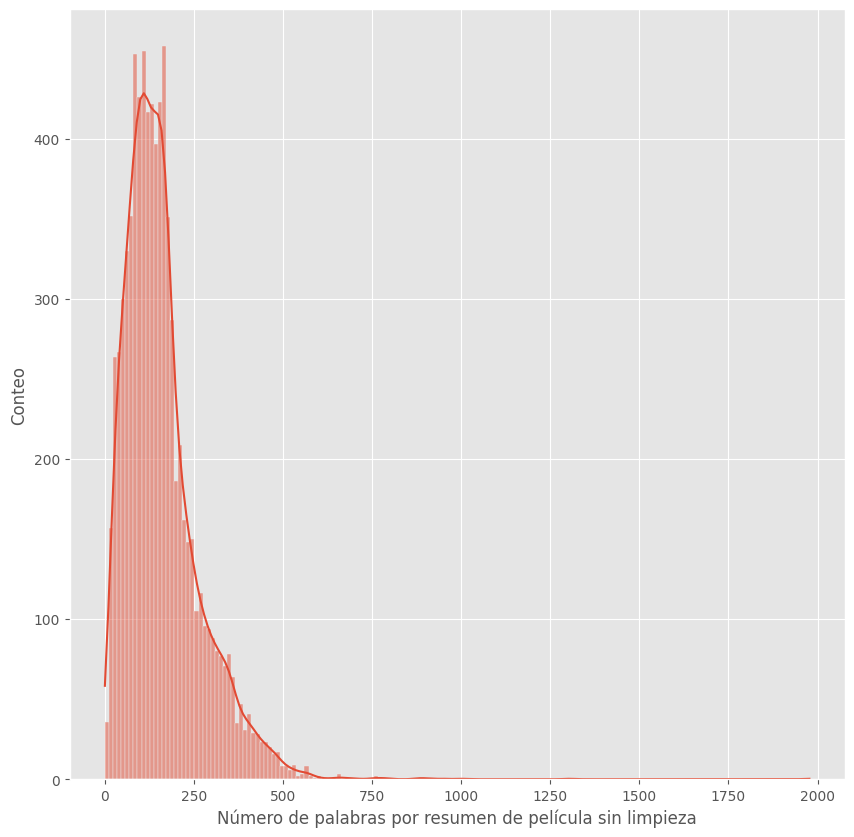

In [10]:
def to_spacy(df, nlp):
    texts=df.tolist()
    corpus=list(nlp.pipe(texts, n_process=4))
    return corpus
def token_count(corpus):
    counts = []
    for doc in corpus:
      stopword_count = len([token for token in doc])
      counts.append(stopword_count)
    return counts
no_prepo = to_spacy(dt["plot"], nlp)
counts = token_count(no_prepo)
print(pd.Series(counts).describe())
fig, ax = plt.subplots()
sns.histplot(counts, kde=True, ax=ax)
ax.set_xlabel("Número de palabras por resumen de película sin limpieza")
ax.set_ylabel("Conteo")
fig.show()

# Estadísticas del número de palabras en el resumen por película con preprocesamiento

In [11]:
def preprocess(text,min_len=2, max_len=23):
    pat = re.compile(r"[^a-z ]")
    spaces = re.compile(r"\s{2,}")

    # Normalizamos el texto
    norm_text = unidecode(text)
    doc = nlp(norm_text)

    # Eliminamos stopwords
    filtered_tokens = filter(lambda token: not token.is_stop, doc )

    # Filtramos palabras por longitud
    filtered_tokens2 = filter(lambda token: len(token) >= min_len
                              and len(token) <= max_len, filtered_tokens)

    # Obtenemos los lemmas de cada token
    lemmas = map(lambda token: token.lemma_, filtered_tokens2 )
    stem = map( lambda token: snow_stemmer.stem(token), lemmas )
    lemma_text = " ".join(stem)

    # Quitamos grafía
    lower_text = lemma_text.lower()

    # Eliminamos caracteres especiales
    clean_text = re.sub(pat, "", lower_text)

    # Eliminamos espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)
    return spaces_text.strip()
prepo_text=list(nlp.pipe(dt["plot"].apply(preprocess).tolist(), n_process=-1))

In [12]:
dt['preprocessed_plot'] = [doc.text for doc in prepo_text]

count    7895.000000
mean       62.569728
std        40.303978
min         0.000000
25%        35.000000
50%        55.000000
75%        80.000000
max       758.000000
dtype: float64


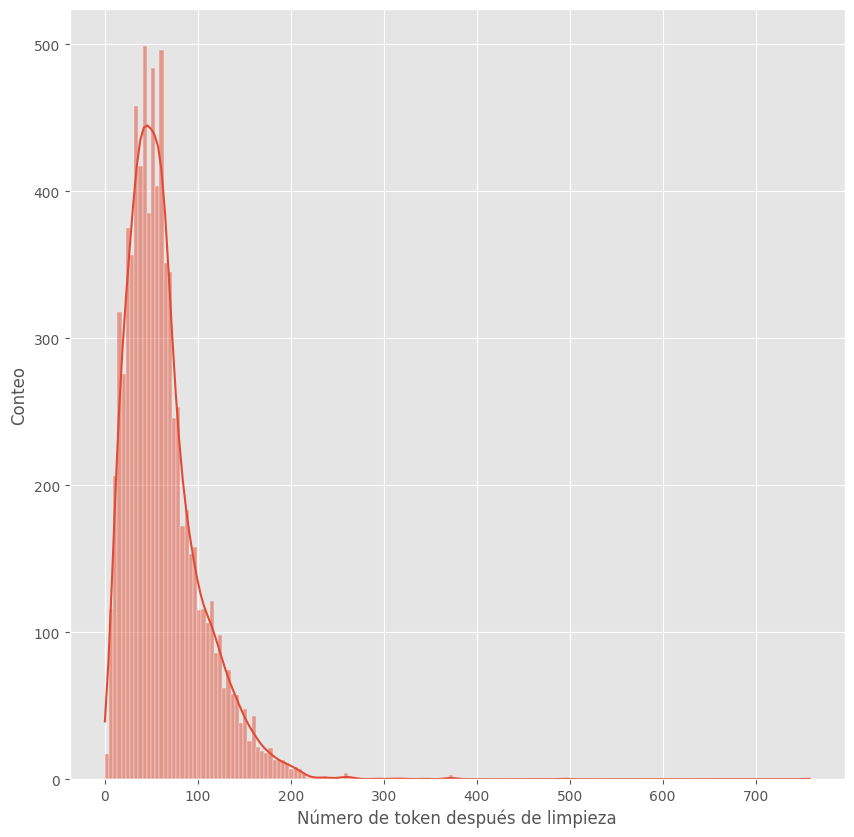

In [13]:
plt.rcParams['figure.figsize'] = [10, 10]
countsp = token_count(prepo_text)
print(pd.Series(countsp).describe())
fig, ax = plt.subplots()
sns.histplot(countsp, kde=True, ax=ax)
ax.set_xlabel("Número de token después de limpieza")
ax.set_ylabel("Conteo")
fig.show()

#  Preprocesamiento Variable objetivo

In [14]:
dt["genres"] = dt["genres"].apply(lambda x: x.replace('[','').replace(']','').replace("\'",''))
dt.head()

,plot,genres,preprocessed_plot
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...


In [15]:
genres_df = dt['genres'].str.get_dummies(sep=', ')
data = dt.drop(['genres','preprocessed_plot'], axis=1)
data = pd.concat([dt, genres_df], axis=1)
data.head()

,plot,genres,preprocessed_plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Distribución de géneros  la base de datos

<Axes: xlabel='index'>

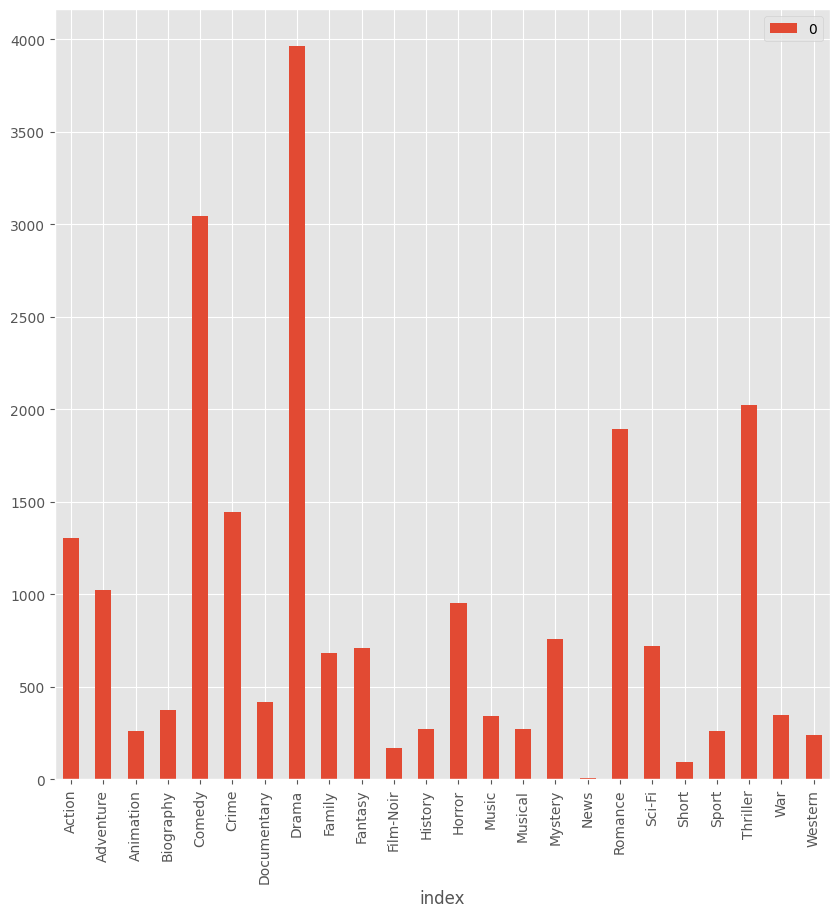

In [16]:
plt.rcParams['figure.figsize'] = [10, 10]
pd.DataFrame(data.iloc[:,3:].sum(),index=data.iloc[:,3:].sum().index).reset_index().plot.bar(x='index', y=0, rot=90)

In [17]:
data[data.News==1].iloc[:,3:].sum()

Action         0
Adventure      0
Animation      0
Biography      3
Comedy         0
Crime          3
Documentary    7
Drama          3
Family         0
Fantasy        0
Film-Noir      0
History        3
Horror         0
Music          0
Musical        0
Mystery        0
News           7
Romance        0
Sci-Fi         0
Short          0
Sport          0
Thriller       1
War            0
Western        0
dtype: int64

In [18]:
data.iloc[:,3:].sum()

Action         1303
Adventure      1024
Animation       260
Biography       373
Comedy         3046
Crime          1447
Documentary     419
Drama          3965
Family          682
Fantasy         707
Film-Noir       168
History         273
Horror          954
Music           341
Musical         271
Mystery         759
News              7
Romance        1892
Sci-Fi          723
Short            92
Sport           261
Thriller       2024
War             348
Western         237
dtype: int64

# Cantidad de géneros por película

count    7895.000000
mean        2.732869
std         1.181396
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         9.000000
dtype: float64


<Axes: >

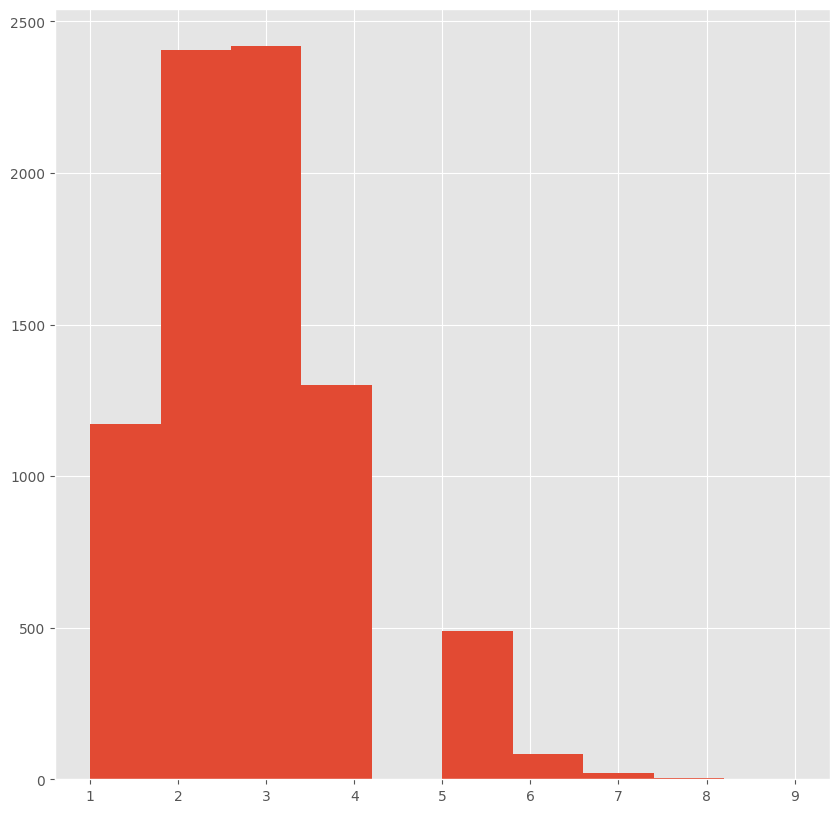

In [19]:
print(data.iloc[:,3:].sum(axis=1).describe())
data.iloc[:,3:].sum(axis=1).hist()

# Embedding de la variable plot con limpieza de tokens

In [21]:
vect = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=0.03).fit(dt.preprocessed_plot)
display(vect)

features = vect.transform(dt.preprocessed_plot).toarray()
display(features.shape)

X_dtm = vect.fit_transform(dt['preprocessed_plot'])
X_dtm_dense = pd.DataFrame(X_dtm.toarray(), columns=vect.get_feature_names_out())
X_dtm_dense.head()

TfidfVectorizer(max_df=0.95, min_df=0.03, sublinear_tf=True)

(7895, 280)

,abl,accept,act,action,affair,age,agent,american,angel,apart,...,well,wife,win,woman,work,world,write,year,york,young
0,0.135838,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.203906,0.154951,0.0,0.0,0.084050,0.000000,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.246068,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.235885,...,0.0,0.172188,0.0,0.167486,0.000000,0.0,0.0,0.144883,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.140102,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.218443,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


# Nubes de Palabras por género

In [22]:
emb=[]
target=[]
for i in range(data.shape[0]):
  for j in data.genres[i].split(', '):
    emb.append(features[i])
    target.append(j)
emb=np.array(emb)
target=np.array(target)
print(emb.shape,target.shape)

(21576, 280) (21576,)


In [23]:
rep_gen=pd.DataFrame(emb,columns=vect.get_feature_names_out())
rep_gen["one_genre"]=target
rep_gen

,abl,accept,act,action,affair,age,agent,american,angel,apart,...,wife,win,woman,work,world,write,year,york,young,one_genre
0,0.135838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.203906,0.154951,0.0,0.0,0.08405,0.0,0.0,Short
1,0.135838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.203906,0.154951,0.0,0.0,0.08405,0.0,0.0,Drama
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,Comedy
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,Crime
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21571,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,Sci-Fi
21572,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,Animation
21573,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,Adventure
21574,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,Family


In [24]:
cloudC=rep_gen.groupby("one_genre").sum().T
cloudC.head()

one_genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
abl,8.204052,8.194770,1.009494,2.727988,28.666316,12.026071,1.418983,38.730092,7.746569,9.127952,...,2.460278,7.602542,0.000000,22.888837,6.145373,0.494324,2.123877,15.645299,4.924415,2.366428
accept,7.995062,7.794544,2.345597,2.188673,25.381592,11.552788,2.075920,34.872337,6.189494,3.684944,...,2.446862,5.672464,0.000000,21.254595,4.855326,0.420787,3.371248,17.465890,1.631442,2.541010
act,7.636147,5.086110,0.898087,3.678553,27.575749,11.959784,1.711660,31.884753,3.993747,4.157950,...,3.839564,5.252772,0.000000,18.439353,5.458181,0.326135,1.494375,15.536144,2.563020,2.356160
action,17.256948,10.755167,4.337731,3.294010,20.402678,14.887624,3.327536,30.731411,7.671059,7.401127,...,2.111397,3.881536,0.385004,7.907120,4.372283,0.613413,1.176510,18.534261,7.782476,1.852046
affair,4.763068,1.995559,0.000000,2.208034,25.402413,14.572861,0.000000,43.449293,0.168458,2.104867,...,1.643565,8.637523,0.000000,30.947546,1.141078,0.000000,0.507696,17.384345,2.403043,0.208432


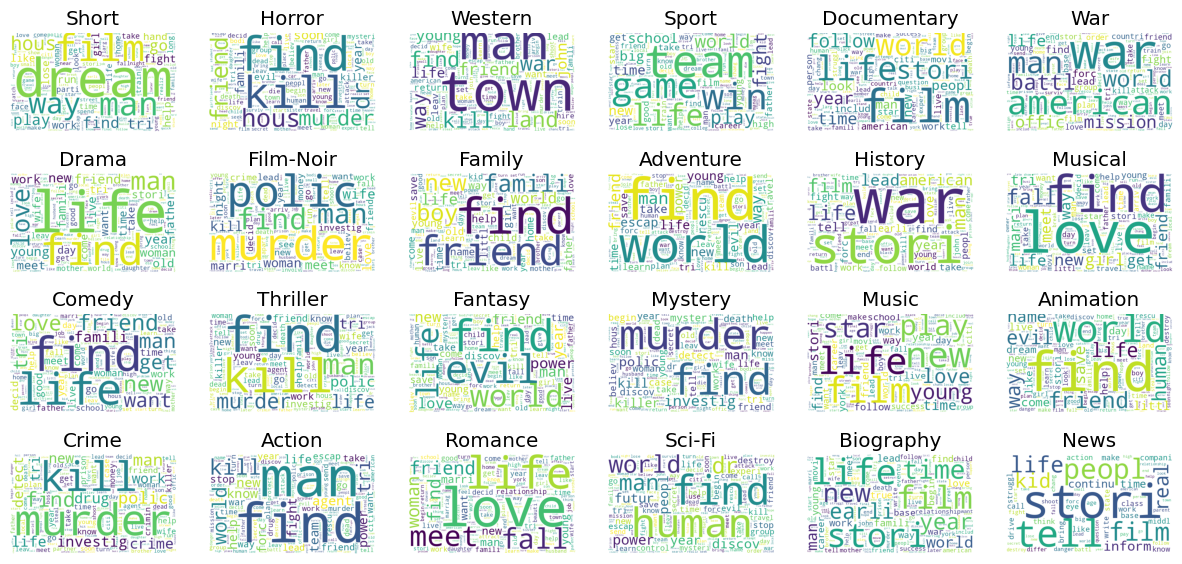

In [25]:
from wordcloud import WordCloud
fig, axes = plt.subplots(4, 6, figsize=(15, 7))
cause=rep_gen["one_genre"].unique()
for j in range(len(cause)):
  ax = axes[j%4,int(j/4)]
  dicti = {word: count for word, count in zip(cloudC.index, cloudC.loc[:,cause[j]].values)}
  wc = (
          WordCloud( width=500, height=300,background_color="white")
          .generate_from_frequencies(dicti)
          )
  ax.imshow(wc)
  ax.set_title(cause[j])
  ax.axis("off")

# TruncatedSVD


In [26]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=250, n_iter=7, random_state=42)
svd.fit(rep_gen.iloc[:,:-1])


TruncatedSVD(n_components=250, n_iter=7, random_state=42)

In [27]:
print(svd.explained_variance_ratio_.sum())

0.9467538190671654


In [28]:
tru=svd.transform(rep_gen.iloc[:,:-1])
trug=pd.DataFrame(tru)
trug["genres"]=target
trug.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,genres
0,0.414107,-0.053755,0.000533,0.021446,0.103546,-0.037661,-0.027131,-0.044706,0.126389,0.138887,...,0.012717,0.004741,-0.055973,0.020868,-0.011021,0.005879,0.072340,-0.044274,0.016617,Short
1,0.414107,-0.053755,0.000533,0.021446,0.103546,-0.037661,-0.027131,-0.044706,0.126389,0.138887,...,0.012717,0.004741,-0.055973,0.020868,-0.011021,0.005879,0.072340,-0.044274,0.016617,Drama
2,0.107467,0.092674,-0.030022,0.051069,-0.003584,-0.005991,0.025652,0.043422,-0.029951,-0.120041,...,0.026938,0.026586,-0.010125,-0.002600,-0.020791,-0.038345,0.017903,0.027137,-0.084003,Comedy
3,0.107467,0.092674,-0.030022,0.051069,-0.003584,-0.005991,0.025652,0.043422,-0.029951,-0.120041,...,0.026938,0.026586,-0.010125,-0.002600,-0.020791,-0.038345,0.017903,0.027137,-0.084003,Crime
4,0.107467,0.092674,-0.030022,0.051069,-0.003584,-0.005991,0.025652,0.043422,-0.029951,-0.120041,...,0.026938,0.026586,-0.010125,-0.002600,-0.020791,-0.038345,0.017903,0.027137,-0.084003,Horror


# Visualización de la nube de catégorias

<Axes: xlabel='0', ylabel='1'>

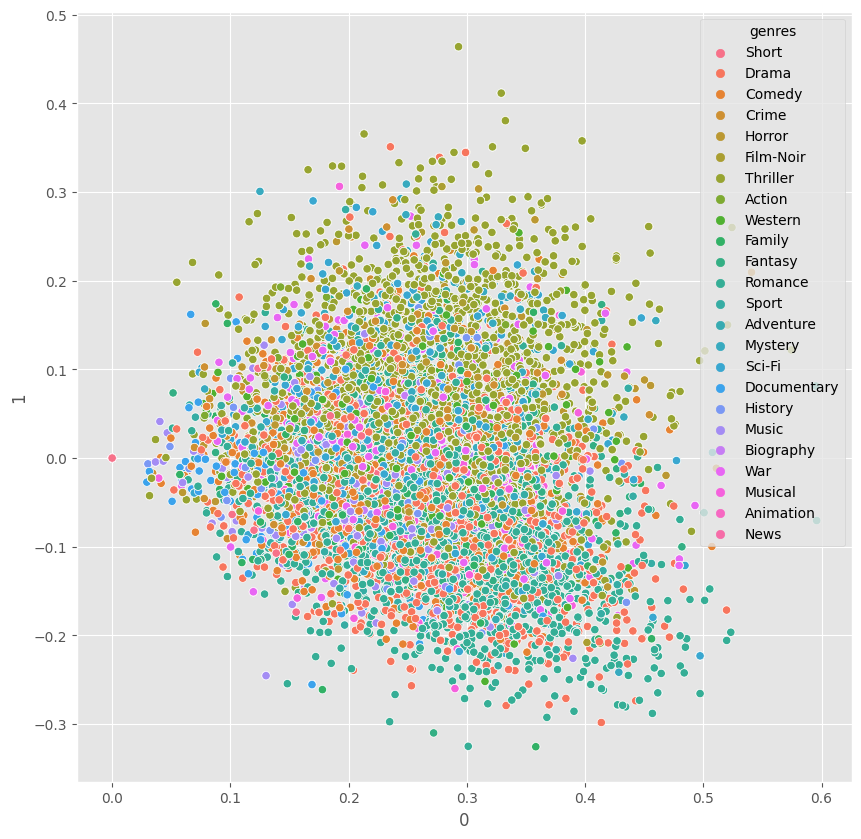

In [30]:
sns.scatterplot(data=trug, x=0, y=1, hue="genres")

<Axes: xlabel='0', ylabel='2'>

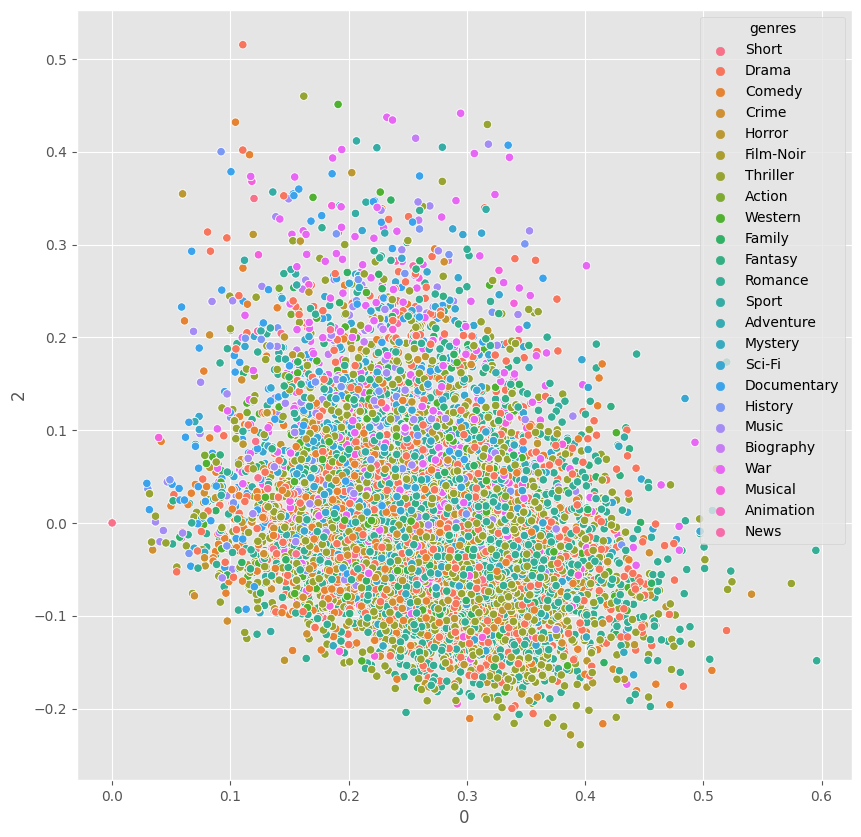

In [31]:
sns.scatterplot(data=trug, x=0, y=2, hue="genres")

# Conteo de veces que un género aparece en la misma película que otro

<Axes: >

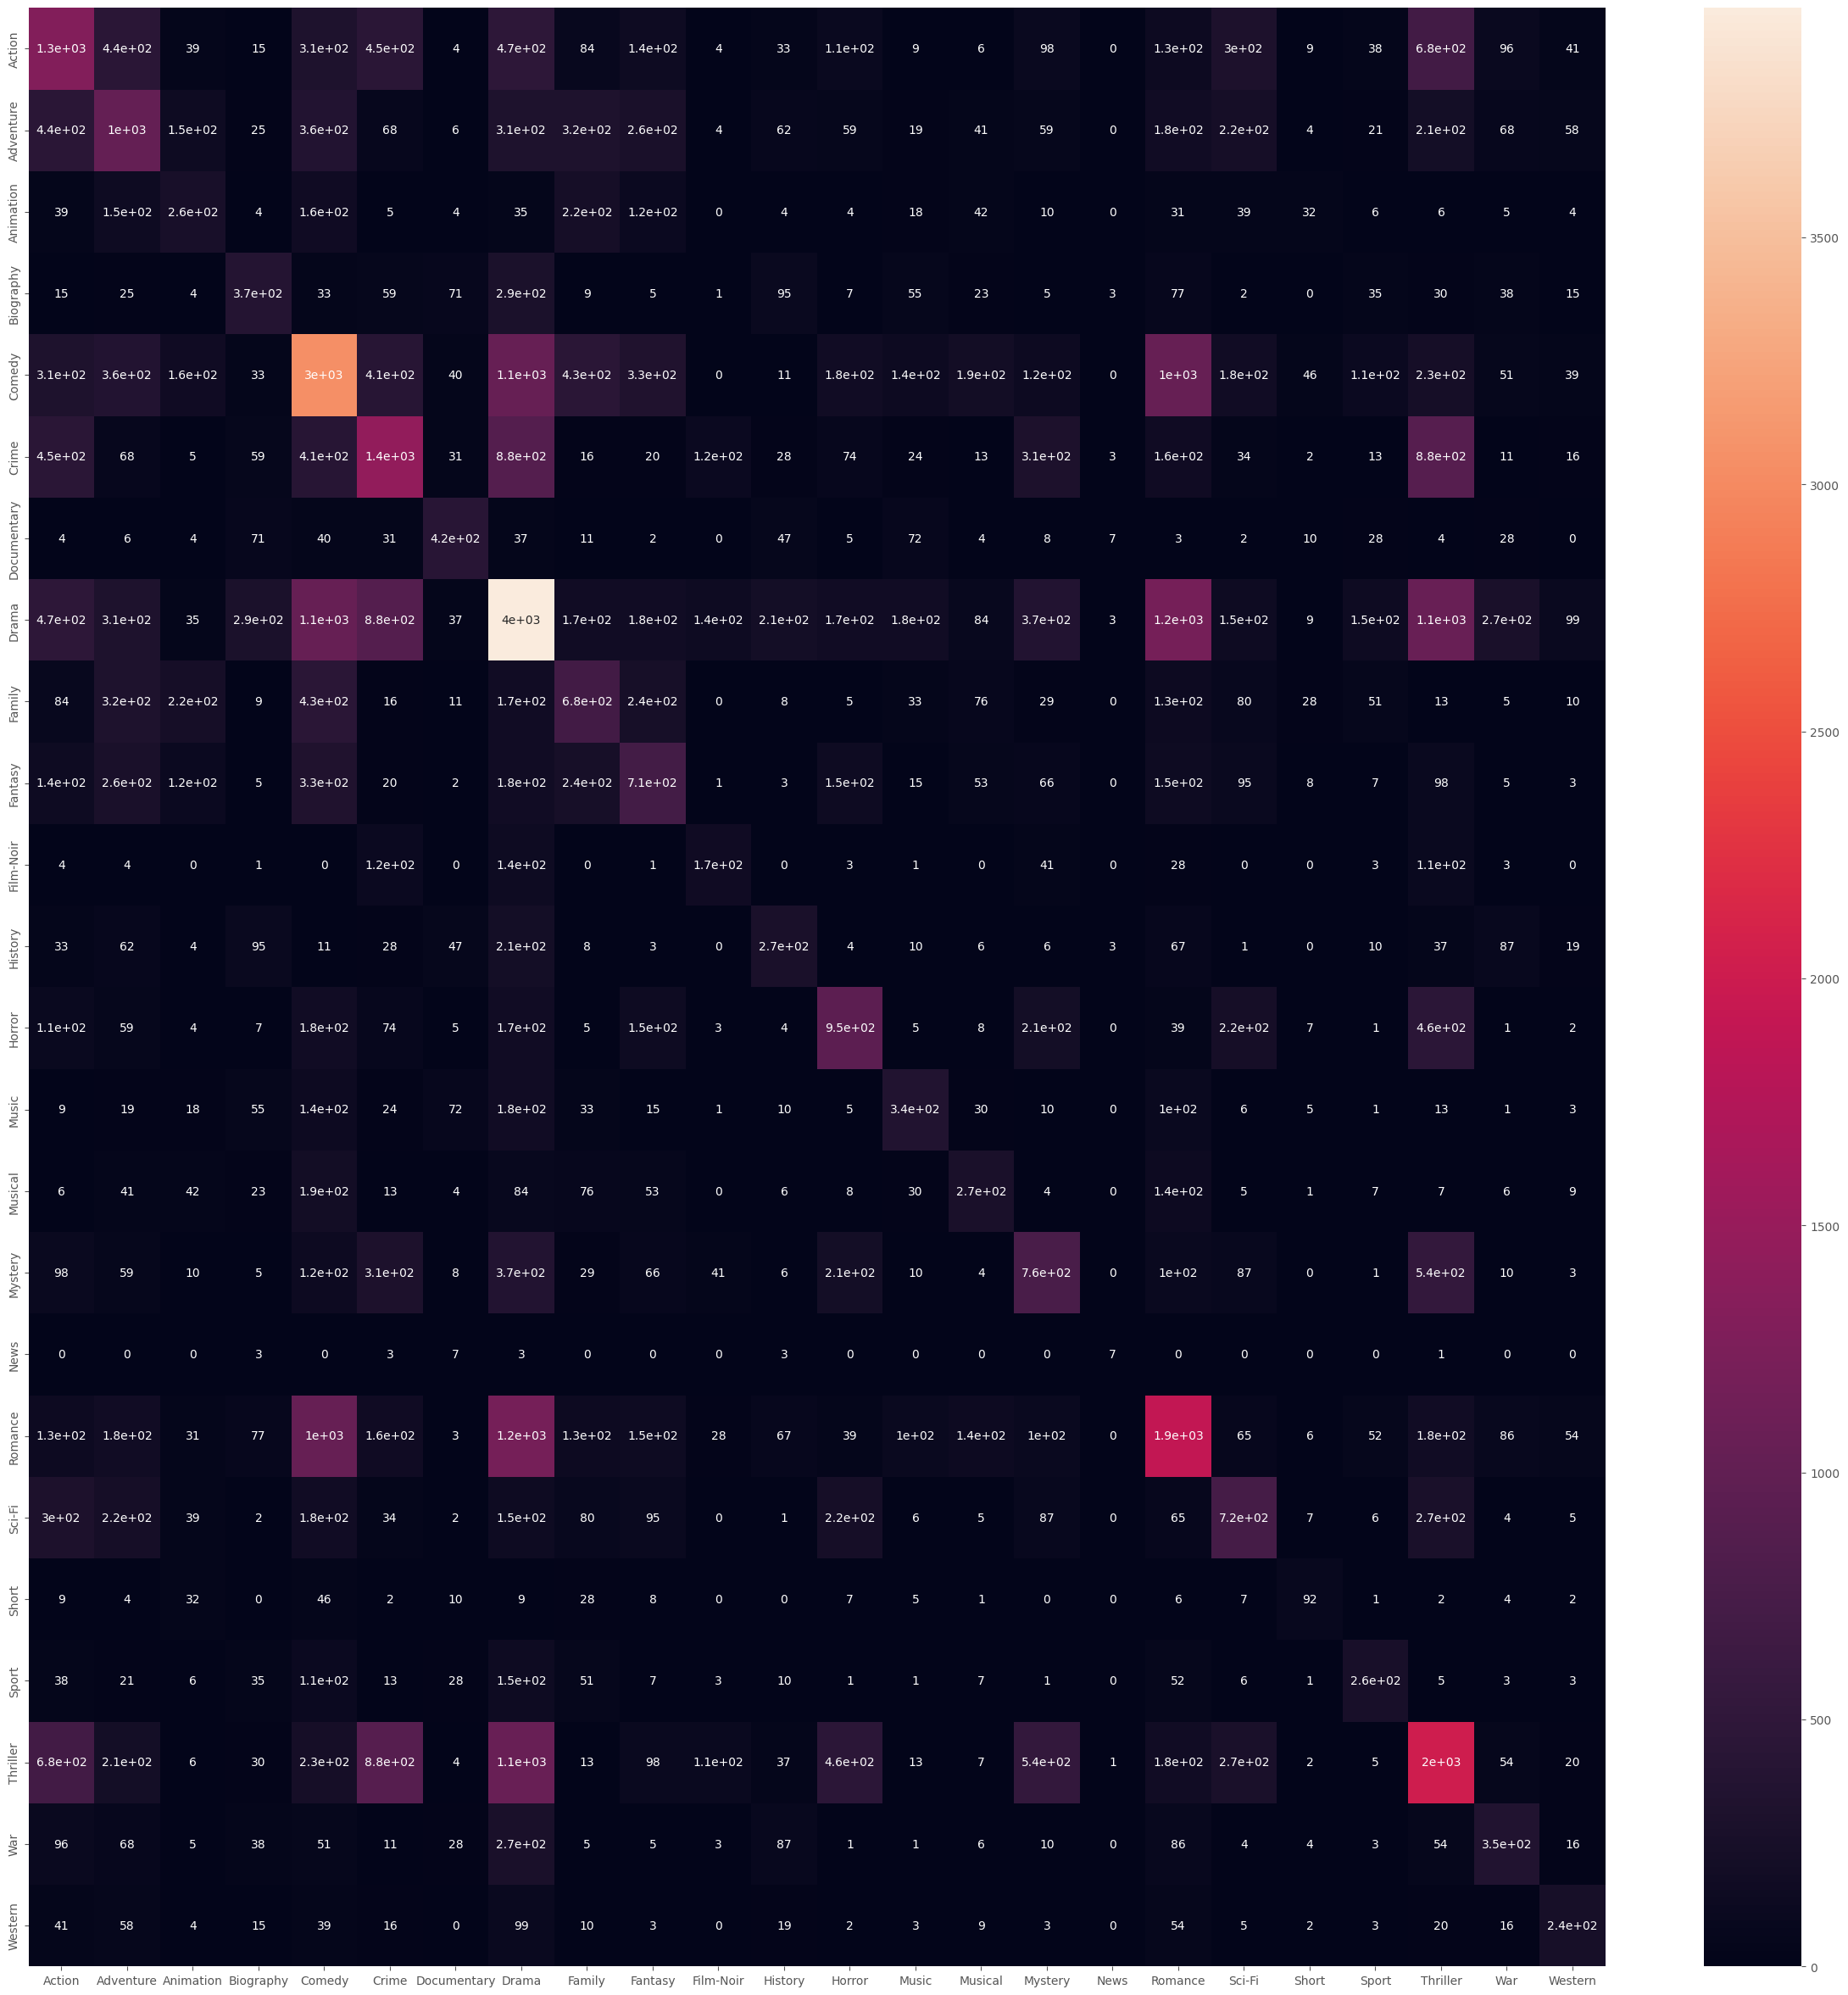

In [36]:
plt.rcParams['figure.figsize'] = [30, 30]
sns.heatmap(data.drop(["plot","genres","preprocessed_plot"],axis=1).T.dot(data.drop(["plot","genres","preprocessed_plot"],axis=1)).T,annot=True)